# Compare HUX Technique results with in-situ spacecraft observations


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import datetime as dt 


from heliopy.data import psp
from heliopy.data import omni
from heliopy.data import stereo
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u
from heliopy.data.solo import download

from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
from pathlib import Path
from parfive import Downloader
from scipy.interpolate import interpn
import pickle

# matplotlib fontsize
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) CR2210 solutions 

Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [2]:
download_dir = Path.cwd() / '..' / '..' / 'data'

mas_helio_dir = download_dir / 'mas_helio'
mas_helio_dir.mkdir(parents=True, exist_ok=True)
base_url = 'http://www.predsci.com/data/runs/cr2210-medium/hmi_mast_mas_std_0201/helio/{var}002.hdf'

# Create a downloader to queue the files to be downloaded
dl = Downloader()

vars = ['rho', 'vr', 'br']
for var in vars:
    file = mas_helio_dir / f'{var}002.hdf'
    if file.exists():
        continue
    else:
        remote_file = base_url.format(var=var)
        dl.enqueue_file(remote_file, path=mas_helio_dir)

# Download the files
if dl.queued_downloads > 0:
    dl.download()
mas_path = mas_helio_dir.resolve()

In [3]:
# mas output - br, rho, vr
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [4]:
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2*pi)
p = vr_model.phi_coords
# sin(theta) - (-1, 1)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [6]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [8]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [9]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [10]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [11]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

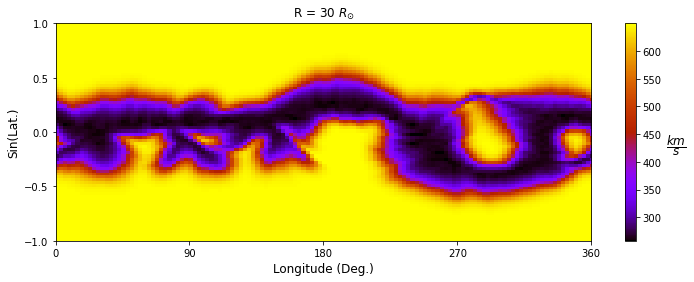

In [12]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/vr_30rs_map.png')

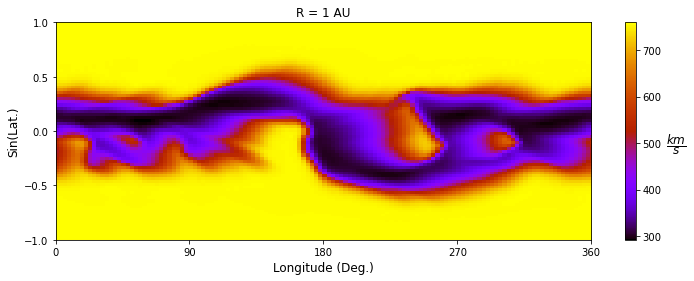

In [13]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/vr_1au_map.png')

# Apply HUX-f

In [14]:
def apply_hux_f_model(r_initial, r, p, dr_vec, dp_vec, alpha=0.15, rh=50, add_v_acc=True, omega_rot=(2*np.pi)/(25.38*86400)):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    
    v = np.zeros((len(r), len(p))) # initialize array vr.
    v[0, :] = r_initial

    if add_v_acc:
        v_acc = alpha * (v[0, :]*(1 - np.exp(-r[0]/rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(r) -1):
        for j in range(len(p)):

            if j == len(p) -1: # force periodicity 
                v[i+1, j] = v[i+1, 0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v[i,j]) > 1:
                    print(dr_vec[i] - dp_vec[j]*v[i,j]/omega_rot) 
                    print(i, j) # courant condition

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1*frac2
            
    return v

In [15]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec=r_plot[1:] - r_plot[:-1]
dp_vec=p[1:] - p[:-1]

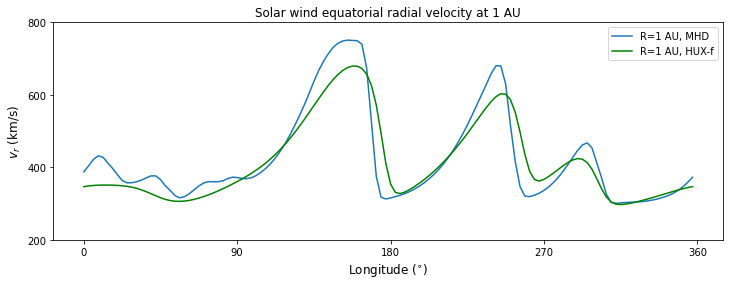

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))
_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="R=1 AU, MHD")
_ = ax.plot(p*180/np.pi, apply_hux_f_model(solar_equator_r_30_radii, r, p, dr_vec, dp_vec, 0.15, 50)[-1, :], 'g',label="R=1 AU, HUX-f")
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/vr_1AU_ts_comp_MHD_HUX-f_.png')

In [17]:
# apply the hux technique to all theta slices
hux_f_res = np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], r, p, dr_vec, dp_vec,
                                            0.15, 50).T

In [18]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0,:, :]],axis=0)

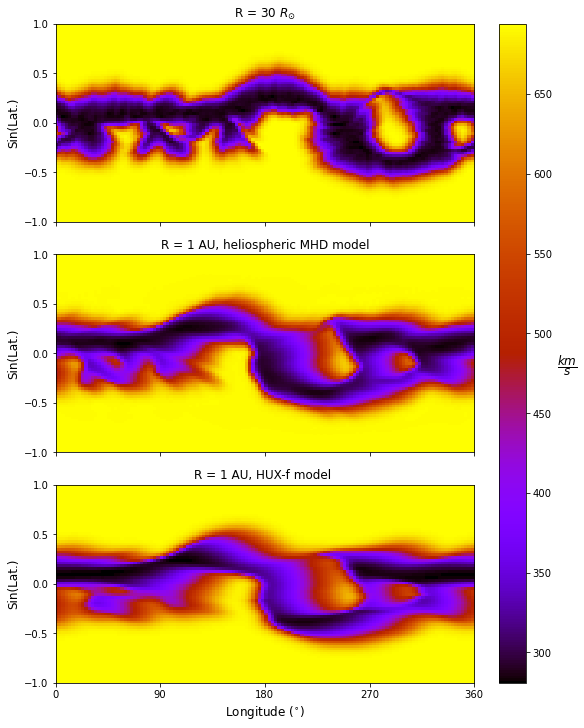

In [19]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)


ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/vr_lon_lat_maps_30rs_MHD_HUX-f.png')

# Read in PSP observations

Here we load the merged magnetic field and plasma data product, which has
an hourly data cadence.

In [20]:
# initialize start and end time for CR2210
starttime = dt.datetime(year=2018, month=10, day=26)
endtime = dt.datetime(year=2018, month=11, day=23)

In [21]:
psp_data = psp.merged_mag_plasma(starttime, endtime)
print(psp_data.columns)

['radialDistance', 'heliographicLatitude', 'heliographicLongitude', 'BR', 'BT', 'BN', 'B', 'VR', 'VT', 'VN', 'ProtonSpeed', 'flow_theta', 'flow_lon', 'protonDensity', 'protonTemp']


In [22]:
psp_data.data

,radialDistance,heliographicLatitude,heliographicLongitude,BR,BT,BN,B,VR,VT,VN,ProtonSpeed,flow_theta,flow_lon,protonDensity,protonTemp
Time,,,,,,,,,,,,,,,
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0


Generate the PSP trajectory.

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.



In [23]:
times = psp_data.index

spicedata.get_kernel('psp')
spicedata.get_kernel('psp_pred')
psp_traj = spice.Trajectory('SPP')
psp_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
psp_coords = psp_traj.coords

In [24]:
psp_data.units

OrderedDict([('Epoch', Unit("ms")),
             ('radialDistance', Unit("AU")),
             ('heliographicLatitude', Unit("deg")),
             ('heliographicLongitude', Unit("deg")),
             ('BR', Unit("nT")),
             ('BT', Unit("nT")),
             ('BN', Unit("nT")),
             ('B', Unit("nT")),
             ('VR', Unit("km / s")),
             ('VT', Unit("km / s")),
             ('VN', Unit("km / s")),
             ('ProtonSpeed', Unit("km / s")),
             ('flow_theta', Unit("deg")),
             ('flow_lon', Unit("deg")),
             ('protonDensity', Unit("N / cm3")),
             ('protonTemp', Unit("deg K"))])

# TODO FIGURE OUT THE DIFFERENCE IN COORDINATE SYSTEMS... 

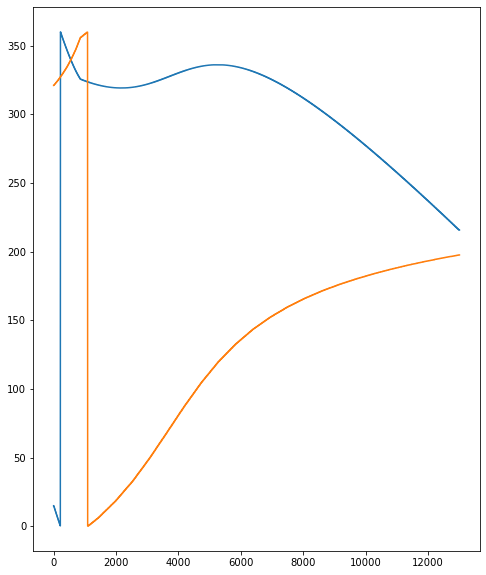

In [25]:
plt.plot(psp_coords.lon)


plt.plot(psp_data.data["heliographicLongitude"].array.to_numpy())

Take a sample of the radial velocity.

Here we start by getting the radial velocity `Variable` from the model, and
then use the PSP corodinate information to sample it.


In [26]:
hux_model = copy.deepcopy(vr_model)
hux_model.data.data = hux_f_res

In [27]:
vr_sampled_hux = hux_model.sample_at_coords(psp_coords.lon,
                                            psp_coords.lat,
                                            psp_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(psp_coords.lon,
                                           psp_coords.lat,
                                           psp_coords.radius)

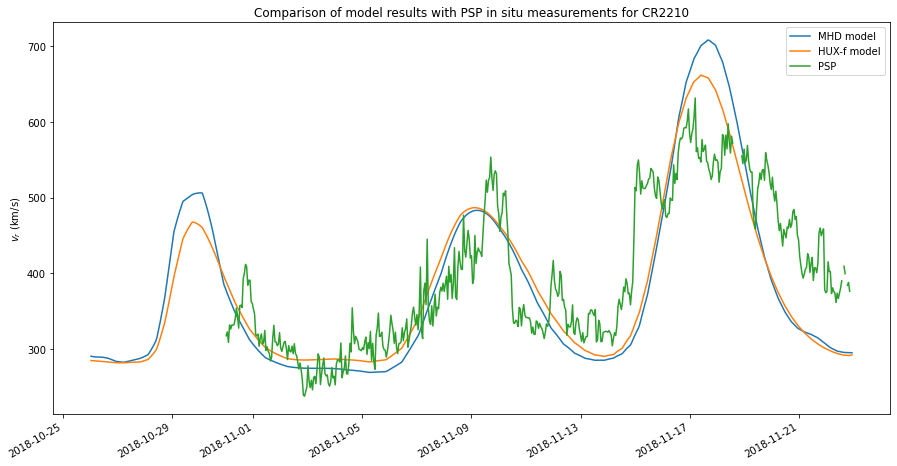

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(times, vr_sampled_mhd, label='MHD model')
ax.plot(times, vr_sampled_hux, label='HUX-f model')
ax.plot(times, psp_data.quantity('VR'), label='PSP')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/psp_comparison_cr2210_time.png')

In [29]:
# lon unit = degree
lon_psp = psp_data.data["heliographicLongitude"].array.to_numpy()
# lat unit = degree
lat_psp = psp_data.data["heliographicLatitude"].array.to_numpy()
# radius unit = AU
r_psp = psp_data.data["radialDistance"].array.to_numpy()
# velocity unit = km/sec
vr_psp = psp_data.data["VR"].array.to_numpy()

In [30]:
# convert lat to -pi/2 to pi/2
lat_psp_rad = (np.pi/180)*lat_psp
# convert radial distance from AU to solar radii
r_psp_rs = r_psp*215.032

In [31]:
mhd_traj = interpn(points=(p_plot,t,r), values=f_plot, xi=np.array([lon_psp,lat_psp_rad,r_psp_rs]).T)
hux_traj = interpn(points=(p_plot,t,r), values=hux_f_res_plot, xi=np.array([lon_psp,lat_psp_rad,r_psp_rs]).T)

In [32]:
min_indx = np.argmin(lon_psp)

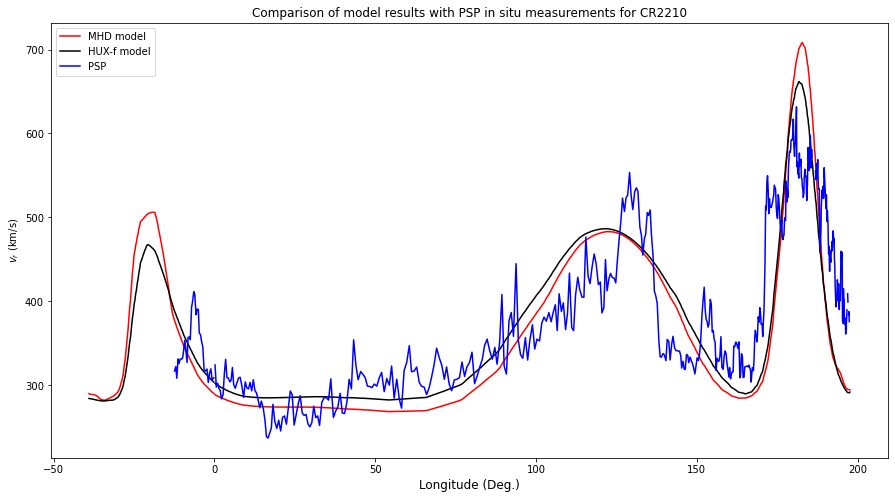

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lon_psp[:min_indx]-360, vr_sampled_mhd[:min_indx], color="r", label="MHD model")
ax.plot(lon_psp[:min_indx]-360, vr_sampled_hux[:min_indx], color="k", label="HUX-f model")
ax.plot(lon_psp[:min_indx]-360, vr_psp[:min_indx], color="b", label="PSP")

ax.plot(lon_psp[min_indx:], vr_sampled_mhd[min_indx:], color="r")
ax.plot(lon_psp[min_indx:], vr_sampled_hux[min_indx:], color="k")
ax.plot(lon_psp[min_indx:], vr_psp[min_indx:], color="b")


ax.set_ylabel(r'$v_{r}$ (km/s)')
#ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
ax.legend()
# plt.savefig('figures/psp_comparison_cr2210_carrington_longitude.png')

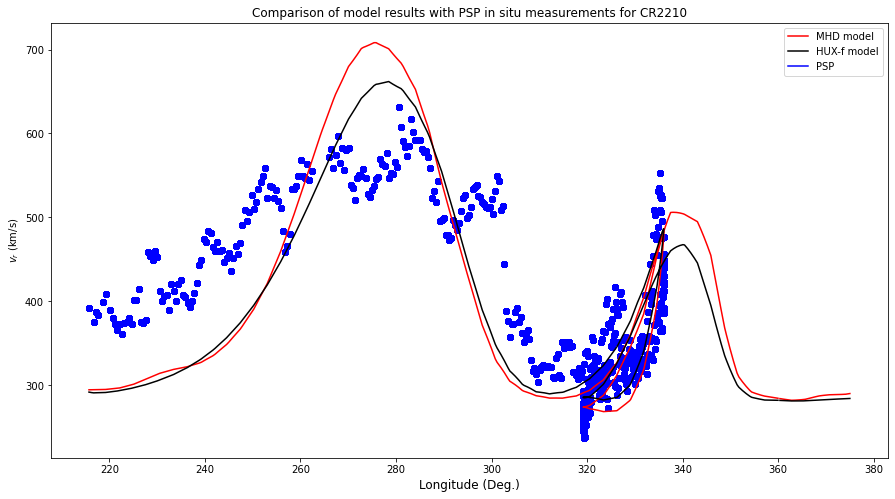

In [34]:
lon_psp = np.array(psp_coords.lon)

max_indx=np.argmax(lon_psp)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lon_psp[:max_indx]+360, vr_sampled_mhd[:max_indx], color="r", label="MHD model")
ax.plot(lon_psp[:max_indx]+360, vr_sampled_hux[:max_indx], color="k", label="HUX-f model")
ax.plot(lon_psp[:max_indx]+360, vr_psp[:max_indx], color="b", label="PSP")

ax.plot(lon_psp[max_indx:], vr_sampled_mhd[max_indx:], color="r")
ax.plot(lon_psp[max_indx:], vr_sampled_hux[max_indx:], color="k")
ax.scatter(lon_psp[max_indx:], vr_psp[max_indx:], color="b")


ax.set_ylabel(r'$v_{r}$ (km/s)')
#ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
ax.legend()
plt.savefig('figures/psp_comparison_cr2210_carrington_longitude.png')

# Read in Earth (OMNI) data


• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

In [35]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

omni_lat = pickle.load( open("data/omni_cr2210_lat.pkl", "rb" ))[1:-2]
omni_lon = pickle.load( open("data/omni_cr2210_lon.pkl", "rb" ))[1:-2]
omni_vr = pickle.load( open("data/omni_cr2210_vr.pkl", "rb" ))[1:-2]

In [36]:
omni_data.quantity("V").unit

Unit("km / s")

In [37]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-26 01:00:00,6.370774e+13,2526,51,52,59,33,5.3,4.6,5.800000,153.600006,...,68.300003,20,-3,9999,7,99999,99999,1.1,0.006018,0.0130
2018-10-26 02:00:00,6.370774e+13,2526,51,52,61,37,5.0,4.3,23.299999,176.800003,...,68.300003,20,2,9999,7,99999,99999,0.2,0.006018,0.0117
2018-10-26 03:00:00,6.370774e+13,2526,51,52,62,36,4.8,4.6,28.000000,123.199997,...,68.300003,13,6,9999,5,99999,99999,0.2,0.006018,0.0091
2018-10-26 04:00:00,6.370775e+13,2526,51,52,61,37,2.2,2.0,4.400000,144.500000,...,68.300003,13,11,9999,5,99999,99999,0.5,0.006018,0.0011
2018-10-26 05:00:00,6.370775e+13,2526,51,52,60,31,2.2,1.9,-1.900000,194.500000,...,68.300003,13,12,9999,5,99999,99999,0.2,0.006018,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 19:00:00,6.371013e+13,2527,51,52,61,34,4.3,4.1,23.200001,332.399994,...,67.500000,3,-2,9999,2,99999,99999,0.1,0.005990,0.0257
2018-11-22 20:00:00,6.371014e+13,2527,51,52,61,36,4.4,4.2,14.100000,316.000000,...,67.500000,3,-1,9999,2,99999,99999,0.0,0.005990,0.0313
2018-11-22 21:00:00,6.371014e+13,2527,51,52,64,39,4.2,3.3,2.200000,264.000000,...,67.500000,0,3,9999,0,99999,99999,0.1,0.005990,0.0152


In [38]:
times = omni_data.index

In [39]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

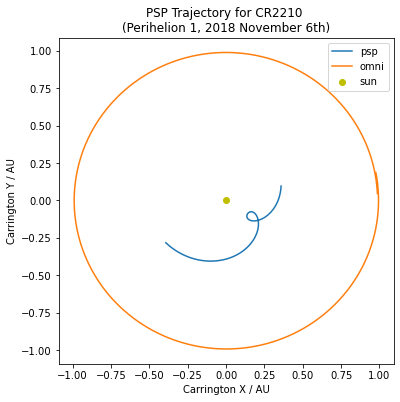

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
_ = ax.plot(psp_coords.radius.to("AU")* np.cos(lon_psp*np.pi/180), psp_coords.radius.to("AU")* np.sin(lon_psp*np.pi/180), label="psp")
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="omni")
_ = ax.scatter(0, 0, color="y", label="sun")
#_ = ax.set_xlim(-1, 1)
#_ = ax.set_ylim(-1, 1)
_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("PSP Trajectory for CR2210 \n(Perihelion 1, 2018 November 6th)")
plt.savefig('figures/psp_cr2210_trajectory_location.png')

In [41]:
vr_sampled_hux_omni = hux_model.sample_at_coords(earth_coords.lon,
                                                 earth_coords.lat,
                                                 earth_coords.radius)

vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

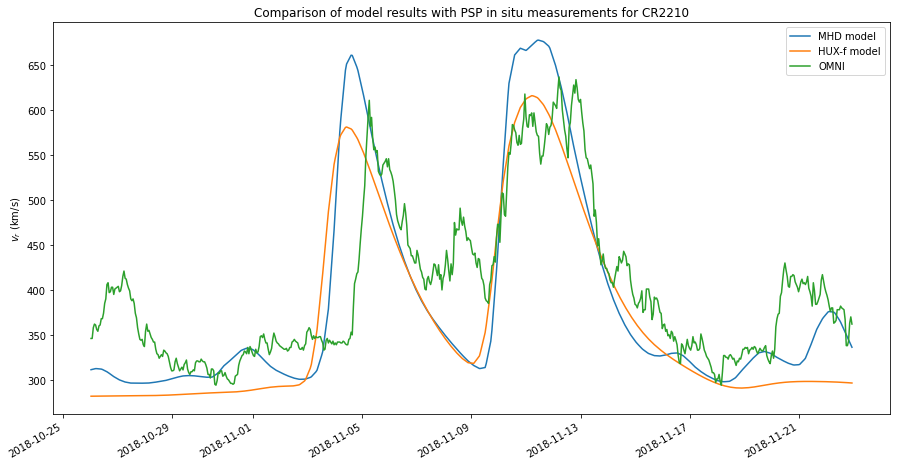

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(times, vr_sampled_mhd_omni, label='MHD model')
ax.plot(times, vr_sampled_hux_omni, label='HUX-f model')
ax.plot(times, omni_vr, label='OMNI')
#ax.plot(times, psp_data.quantity('ProtonSpeed'), label='PSP protonspeed')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/omni_comparison_cr2210_time.png')

In [43]:
min_index = np.argmin(earth_coords.lon)

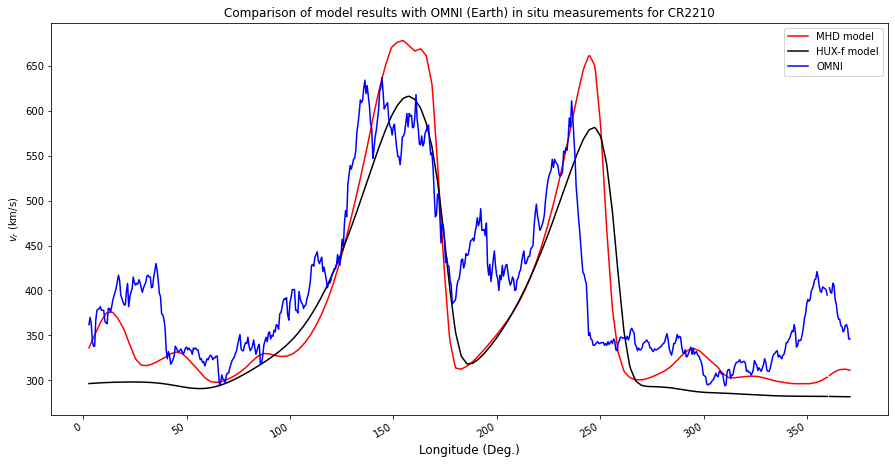

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="r", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_omni[:min_index], color="k", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_vr[:min_index], color="b", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_omni[min_index+1:], color="k")
ax.plot(earth_coords.lon[min_index+1:], omni_vr[min_index+1:], color="b")

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of model results with OMNI (Earth) in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/omni_comparison_cr2210_lon.png')

# First attempt to map PSP to OMNI (Earth) using the HUX Technique

# Assumptions: 
- latitude is constant in psp trajectory coordinates - meaning it does not change in latitude. Note that HUX is dependent of $\phi$ and $r$. 
- psp and earth are aligned in latitude. 
- $\phi$ is monotonically increasing - notice that in perihelion 1 psp orbit loops back and therefore we exclude that section for now. 

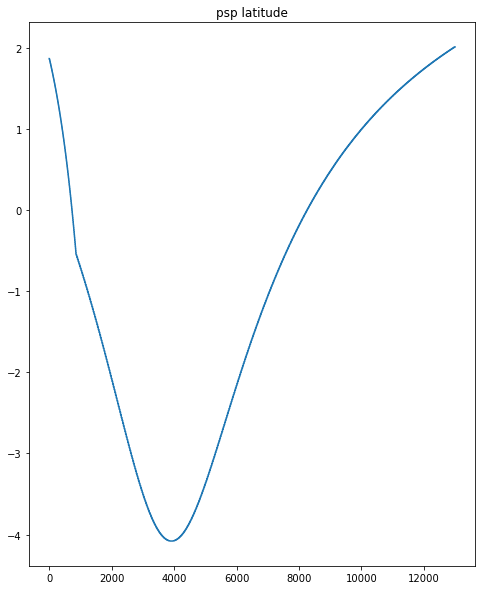

In [45]:
_ = plt.plot(psp_traj.coords.lat)
_ = plt.title("psp latitude")

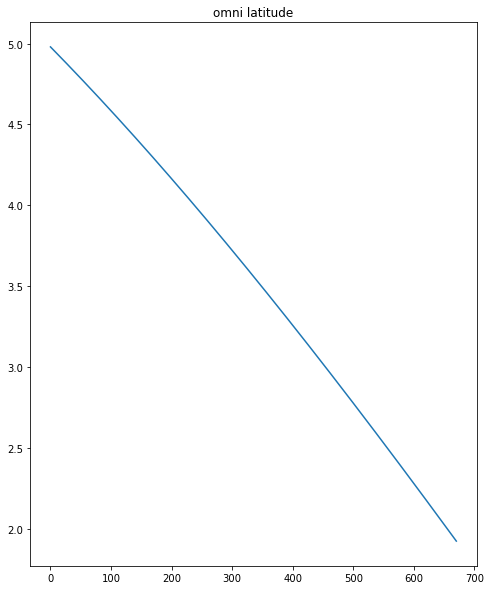

In [46]:
_ = plt.plot(earth_traj.coords.lat)
_ = plt.title("omni latitude")

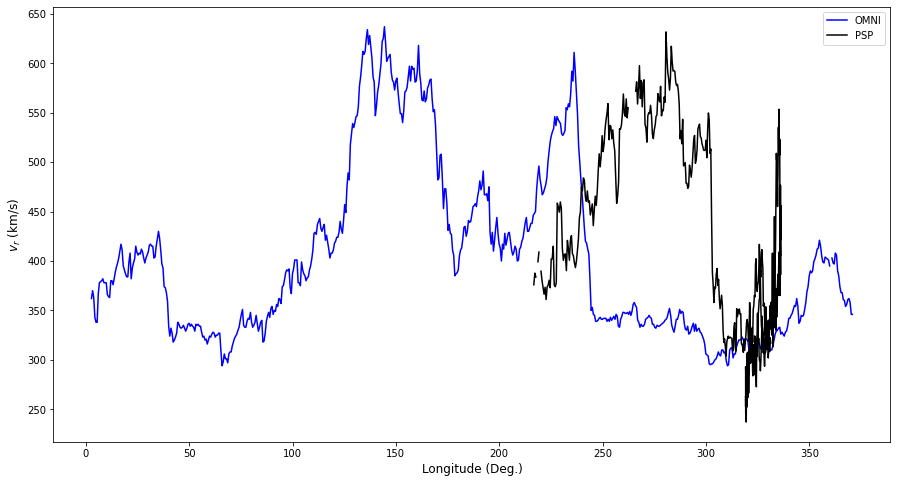

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
_ = ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_vr[:min_index], color="b", label="OMNI")
_ = ax.plot(earth_coords.lon[min_index+1:], omni_vr[min_index+1:], color="b")
_ = ax.plot(lon_psp[:max_indx]+360, vr_psp[:max_indx], color="k", label="PSP")
_ = ax.plot(lon_psp[max_indx:], vr_psp[max_indx:], color="k")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [48]:
phi_array = np.linspace(0, 360, 350)

In [49]:
# interpolate 1D (0, 360)
interp_omni = scipy.interpolate.interp1d(earth_coords.lon,omni_vr, fill_value="extrapolate")
interp_psp = scipy.interpolate.interp1d(psp_coords.lon,vr_psp, bounds_error=False, fill_value="extrapolate")

In [50]:
earth_vr_interp = interp_omni(phi_array)
psp_vr_interp = interp_psp(phi_array)

In [51]:
def apply_forward_upwind_model(r_initial, dr_vec, dp_vec, alpha=0.15, rh=50, add_v_acc=True, r0=30*(695700), omega_rot=(2*np.pi)/(25.38*86400)):
    """ Apply 1d forward upwind model to the inviscid burgers equation. r/phi grid."""

    v_next = np.zeros(len(dp_vec) + 1) # initialize v_next.
    v_prev = r_initial # v_previous, r = 30 RS. 
    
    # add acceleration before upwind. 
    if add_v_acc:
        v_acc = alpha * (v_prev*(1 - np.exp(-r0/rh)))
        v_prev = v_acc + v_prev

    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):

            if j == len(dp_vec): # force periodicity 
                v_next[-1] = v_next[0]

            else:
                # courant condition
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v_prev[j]) > 1:
                    print("CFL violated", dr_vec[i] - dp_vec[j]*v_prev[j]/omega_rot)
                    raise ValueError('CFL violated')
                    return False

                frac1 = (v_prev[j+1] - v_prev[j]) / v_prev[j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v_next[j] = v_prev[j] + frac1*frac2
        
        # update v_prev to be the current v. np.copy- deep copy so when we modify 
        # v_next v_prev does not change. 
        v_prev = np.copy(v_next)

    return v_next

In [52]:
def apply_backwards_upwind_model(r_final, dr_vec, dp_vec, alpha=0.15, rh=50, add_v_acc=True, r0=30*(695700), omega_rot=(2*np.pi)/(25.38*86400)):
    """ Apply 1d backwards upwind model to the inviscid burgers equation. r/phi grid."""
    
    v_next = np.zeros(len(dp_vec)+1) # initialize v_next.
    v_prev = r_final # v_previous, r = 1 AU. 
            
    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):
            
            if j != len(dp_vec):
                # courant condition
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v_prev[j]) > 1:
                    print("CFL violated", dr_vec[i] - dp_vec[j]*v_prev[j]/omega_rot) 
                    raise ValueError('CFL violated')
                    return False
                    
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
            else:
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[0]
                
            frac1 = (v_prev[j-1] - v_prev[j]) / v_prev[j]
            v_next[j] = v_prev[j] + frac1*frac2
            
        # update v_prev to be the current v. np.copy- deep copy so when we modify 
        # v_next v_prev does not change. 
        v_prev = np.copy(v_next)
            
    # add acceleration after upwind. 
    if add_v_acc:
        v_acc = alpha * (v_next*(1 - np.exp(-r0/rh)))
        v_next = -v_acc + v_next
            
    return v_next

In [53]:
# average psp radial position to earth
r_hux = np.linspace(np.mean(psp_coords.radius), np.mean(earth_coords.radius), 150)
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi and delta r vectors
dr_vec_hux = r_hux.value[1:] - r_hux.value[:-1]
dp_vec_hux = p_hux[1:] - p_hux[:-1]

### Note that we set velocity acceleration after upwind to 'False'

In [54]:
res_hux_f = apply_forward_upwind_model(r_initial=np.nan_to_num(psp_vr_interp, nan=350),
                              dr_vec=dr_vec_hux,
                              dp_vec=dp_vec_hux, 
                              add_v_acc=False, 
                              r0=r_hux[0].value)

res_hux_b = apply_backwards_upwind_model(r_final=np.nan_to_num(earth_vr_interp, nan=350), 
                                         dr_vec=dr_vec_hux, dp_vec=dp_vec_hux, r0=r_hux[0].value, 
                                         add_v_acc=False)

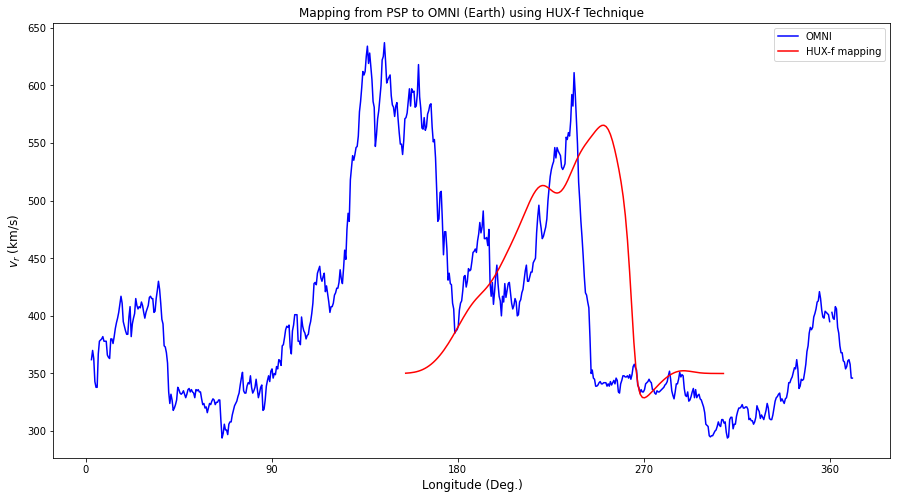

In [55]:
fig, ax = plt.subplots(figsize=(15, 8))
_ = ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_vr[:min_index], color="b", label="OMNI")
_ = ax.plot(earth_coords.lon[min_index+1:], omni_vr[min_index+1:], color="b")
_ = ax.plot(phi_array[150: -50], res_hux_f[150:-50], color="r", label="HUX-f mapping")
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

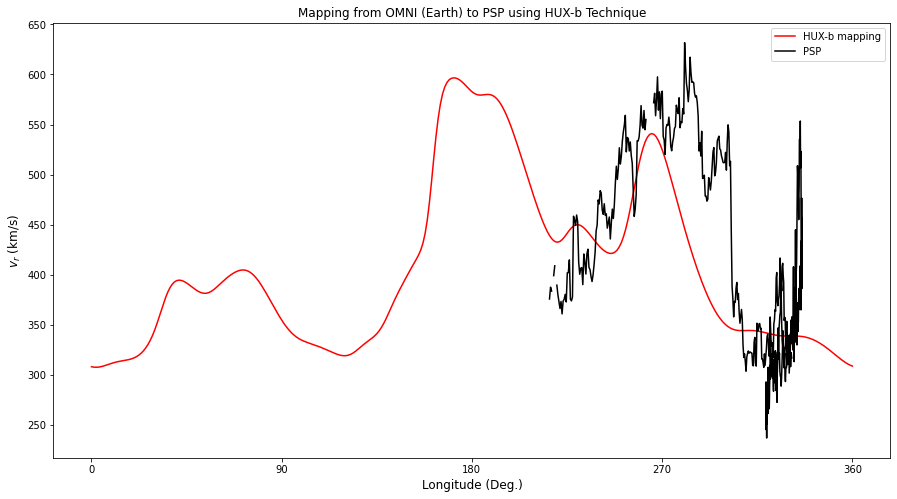

In [56]:
fig, ax = plt.subplots(figsize=(15, 8))
_ = ax.plot(phi_array, res_hux_b, color="r", label="HUX-b mapping")
_ = ax.plot(lon_psp[:max_indx]+360, vr_psp[:max_indx], color="k", label="PSP")
_ = ax.plot(lon_psp[max_indx:], vr_psp[max_indx:], color="k")
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

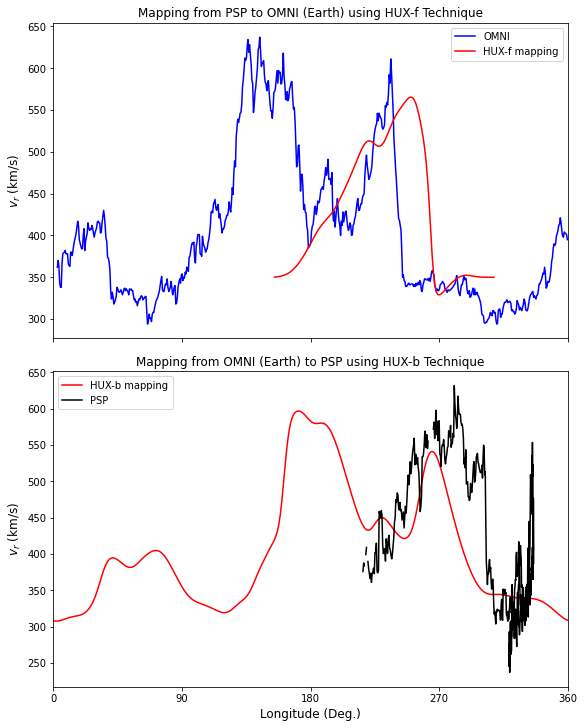

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique", fontsize=fs1)
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
ax[0].plot(np.array(earth_coords.lon[:min_index])+360, omni_vr[:min_index], color="b", label="OMNI")
ax[0].plot(earth_coords.lon[min_index+1:], omni_vr[min_index+1:], color="b")
ax[0].plot(phi_array[150: -50], res_hux_f[150:-50], color="r", label="HUX-f mapping")
#ax[0].plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="g", label="MHD")
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b, color="r", label="HUX-b mapping")
#ax[1].plot(lon_psp[max_indx:], vr_sampled_mhd[max_indx:], color="g", label="MHD")

ax[1].plot(lon_psp[:max_indx]+360, vr_psp[:max_indx], color="k", label="PSP")
ax[1].plot(lon_psp[max_indx:], vr_psp[max_indx:], color="k")
ax[1].legend()
plt.savefig('figures/mapping_omni_to_psp_and_back.png')